In [1]:
import numpy as np
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    eps = 1e-2
    precision = jnp.linalg.inv(cov + eps * jnp.eye(len(mu)))


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [5]:
def sm_loss(params, samples):


    mu = params["mu"]
    L = params["L"]
    prec = L @ L.T


    centered = samples - mu
    prec2 = prec @ prec
    quad_terms = jnp.sum((centered @ prec2) * centered, axis=1)


    loss = 0.5 * jnp.mean(quad_terms) - jnp.trace(prec)
    
    
    return loss

In [6]:
def optimize_a_score_matching_with_tracking(samples, true_mu, true_cov, n_steps=1000, lr=1e-2, delta_enhance=1e-2, max_enhance=5, seed=0):


    d = samples.shape[1]
    key = jax.random.PRNGKey(seed)
    key_mu, key_L = jax.random.split(key)


    mu_init = jax.random.normal(key_mu, shape=(d,))
    L_init = jnp.eye(d) + 0.01 * jax.random.normal(key_L, shape=(d, d))
    L_init = jnp.tril(L_init)


    params = {"mu": mu_init, "L": L_init}
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)


    loss_grad_fn = jax.value_and_grad(sm_loss)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
        "n_samples": [],
    }


    prev_params = params.copy()
    n_enhanced = 0


    for step in range(n_steps):
        loss_val, grads = loss_grad_fn(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        params["L"] = jnp.tril(params["L"])


        mu_hat = params["mu"]
        prec_hat = params["L"] @ params["L"].T
        cov_hat = jnp.linalg.inv(prec_hat)


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_hat))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_hat, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_hat, ord='fro'))
        history["n_samples"].append(samples.shape[0])


        diff_mu = jnp.linalg.norm(params["mu"] - prev_params["mu"])
        diff_L = jnp.linalg.norm(params["L"] - prev_params["L"])
        param_change = diff_mu + diff_L


        if param_change < delta_enhance and n_enhanced < max_enhance:
            evolved = evolve_langevin(samples, mu_hat, cov_hat, eps=1e-2, n_evolution=5, seed=step)
            samples = jnp.concatenate([samples, evolved], axis=0)
            n_enhanced += 1
            print(f"[Enhance #{n_enhanced}] step {step}: added {evolved.shape[0]} samples (total = {samples.shape[0]})")


        prev_params = {k: v.copy() for k, v in params.items()}
        
        
    return params, history

In [7]:
mu10 = jnp.array([0.0, 1.0, -1.0, 0.5, -0.5, 1.5, -1.5, 0.2, -0.2, 0.8])


cov10 = jnp.array([
    [ 1.0,  0.4,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2, -0.3, -0.4],
    [ 0.4,  1.0,  0.5,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2, -0.3],
    [ 0.3,  0.5,  1.0,  0.4,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2],
    [ 0.2,  0.3,  0.4,  1.0,  0.5,  0.3,  0.2,  0.1,  0.0, -0.1],
    [ 0.1,  0.2,  0.3,  0.5,  1.0,  0.4,  0.3,  0.2,  0.1,  0.0],
    [ 0.0,  0.1,  0.2,  0.3,  0.4,  1.0,  0.5,  0.3,  0.2,  0.1],
    [-0.1,  0.0,  0.1,  0.2,  0.3,  0.5,  1.0,  0.4,  0.3,  0.2],
    [-0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.4,  1.0,  0.5,  0.3],
    [-0.3, -0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.5,  1.0,  0.4],
    [-0.4, -0.3, -0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.4,  1.0]
])


mu = jnp.tile(mu10, 5)


cov = jnp.kron(jnp.eye(5), cov10)

In [8]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


params_hat, history = optimize_a_score_matching_with_tracking(
    samples=samples,
    true_mu=mu,
    true_cov=cov,
    n_steps=800,
    lr=1e-2,
    delta_enhance=1e-2,
    max_enhance=5,
    seed=0
)


mu_hat = params_hat["mu"]
precision_hat = params_hat["L"] @ params_hat["L"].T
cov_hat = jnp.linalg.inv(precision_hat)

[Enhance #1] step 135: added 2000 samples (total = 4000)
[Enhance #2] step 163: added 4000 samples (total = 8000)
[Enhance #3] step 184: added 8000 samples (total = 16000)
[Enhance #4] step 200: added 16000 samples (total = 32000)
[Enhance #5] step 201: added 32000 samples (total = 64000)


KeyboardInterrupt: 

In [ ]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(mu_hat, 4), jnp.linalg.norm(mu - mu_hat)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(cov_hat, 4), jnp.linalg.norm(cov - cov_hat)/jnp.linalg.norm(cov), "\n\n\n")

[ 0.  1. -1.] 

 [-0.0711  0.963  -1.0294] 0.06033744 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[1.0746 0.5753 0.233 ]
 [0.5753 1.0896 0.3581]
 [0.233  0.3581 1.0839]] 0.104316026 





In [ ]:
history_np = {k: np.array(v) for k, v in history.items()}

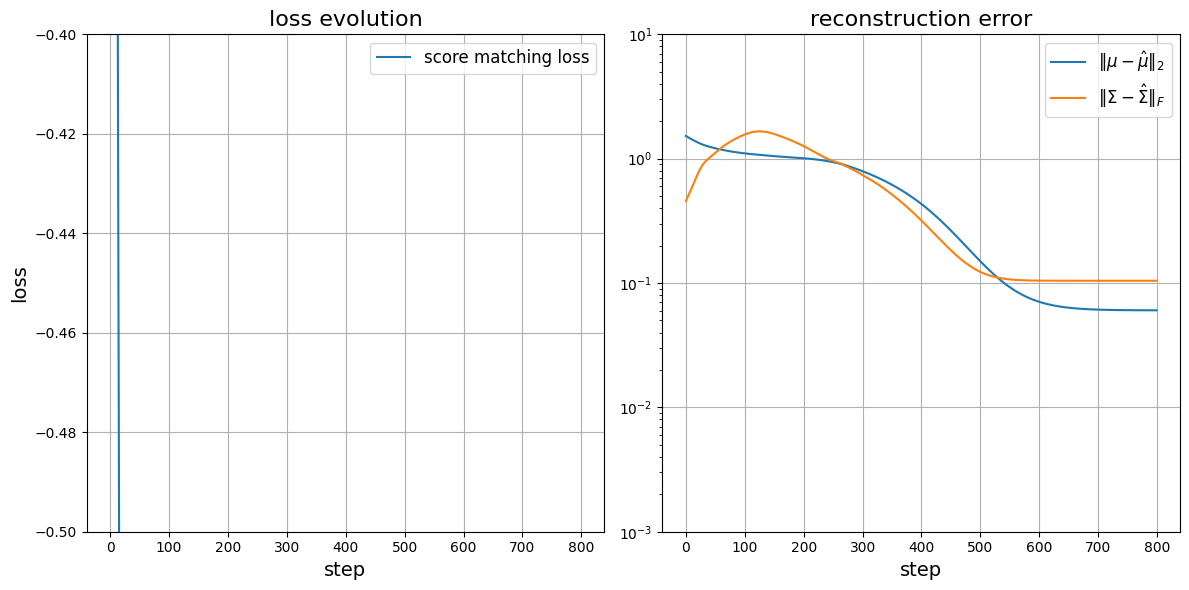

In [ ]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/jnp.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_fro"]/jnp.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [ ]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, history = optimize_a_score_matching_with_tracking(
    samples=samples,
    true_mu=mu,
    true_cov=cov,
    n_steps=800,
    lr=1e-2,
    delta_enhance=1e-2,
    max_enhance=3,
    seed=0
)
    

    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

[Enhance #1] step 242: added 50 samples (total = 100)
[Enhance #2] step 256: added 100 samples (total = 200)
[Enhance #3] step 257: added 200 samples (total = 400)


  2%|▎         | 1/40 [00:02<01:50,  2.83s/it]

[Enhance #1] step 47: added 100 samples (total = 200)
[Enhance #2] step 48: added 200 samples (total = 400)
[Enhance #3] step 49: added 400 samples (total = 800)


  5%|▌         | 2/40 [00:05<01:54,  3.01s/it]

[Enhance #1] step 50: added 150 samples (total = 300)
[Enhance #2] step 51: added 300 samples (total = 600)
[Enhance #3] step 52: added 600 samples (total = 1200)


  8%|▊         | 3/40 [00:08<01:50,  2.99s/it]

[Enhance #1] step 49: added 200 samples (total = 400)
[Enhance #2] step 50: added 400 samples (total = 800)
[Enhance #3] step 51: added 800 samples (total = 1600)


 10%|█         | 4/40 [00:12<01:52,  3.12s/it]

[Enhance #1] step 48: added 250 samples (total = 500)
[Enhance #2] step 49: added 500 samples (total = 1000)
[Enhance #3] step 50: added 1000 samples (total = 2000)


 12%|█▎        | 5/40 [00:15<01:45,  3.02s/it]

[Enhance #1] step 47: added 300 samples (total = 600)
[Enhance #2] step 48: added 600 samples (total = 1200)
[Enhance #3] step 49: added 1200 samples (total = 2400)


 15%|█▌        | 6/40 [00:18<01:43,  3.05s/it]

[Enhance #1] step 54: added 350 samples (total = 700)
[Enhance #2] step 55: added 700 samples (total = 1400)
[Enhance #3] step 66: added 1400 samples (total = 2800)


 18%|█▊        | 7/40 [00:21<01:39,  3.00s/it]

[Enhance #1] step 261: added 400 samples (total = 800)
[Enhance #2] step 262: added 800 samples (total = 1600)
[Enhance #3] step 274: added 1600 samples (total = 3200)


 20%|██        | 8/40 [00:23<01:34,  2.96s/it]

[Enhance #1] step 263: added 450 samples (total = 900)
[Enhance #2] step 264: added 900 samples (total = 1800)
[Enhance #3] step 270: added 1800 samples (total = 3600)


 22%|██▎       | 9/40 [00:26<01:29,  2.90s/it]

[Enhance #1] step 64: added 500 samples (total = 1000)
[Enhance #2] step 266: added 1000 samples (total = 2000)
[Enhance #3] step 267: added 2000 samples (total = 4000)


 25%|██▌       | 10/40 [00:29<01:25,  2.85s/it]

[Enhance #1] step 265: added 550 samples (total = 1100)
[Enhance #2] step 266: added 1100 samples (total = 2200)
[Enhance #3] step 272: added 2200 samples (total = 4400)


 28%|██▊       | 11/40 [00:32<01:23,  2.88s/it]

[Enhance #1] step 57: added 600 samples (total = 1200)
[Enhance #2] step 58: added 1200 samples (total = 2400)
[Enhance #3] step 66: added 2400 samples (total = 4800)


 30%|███       | 12/40 [00:35<01:21,  2.90s/it]

[Enhance #1] step 272: added 650 samples (total = 1300)
[Enhance #2] step 273: added 1300 samples (total = 2600)
[Enhance #3] step 285: added 2600 samples (total = 5200)


 32%|███▎      | 13/40 [00:38<01:19,  2.93s/it]

[Enhance #1] step 267: added 700 samples (total = 1400)
[Enhance #2] step 268: added 1400 samples (total = 2800)
[Enhance #3] step 269: added 2800 samples (total = 5600)


 35%|███▌      | 14/40 [00:41<01:16,  2.95s/it]

[Enhance #1] step 55: added 750 samples (total = 1500)
[Enhance #2] step 56: added 1500 samples (total = 3000)
[Enhance #3] step 57: added 3000 samples (total = 6000)


 38%|███▊      | 15/40 [00:44<01:13,  2.92s/it]

[Enhance #1] step 55: added 800 samples (total = 1600)
[Enhance #2] step 56: added 1600 samples (total = 3200)
[Enhance #3] step 57: added 3200 samples (total = 6400)


 40%|████      | 16/40 [00:47<01:11,  2.98s/it]

[Enhance #1] step 257: added 850 samples (total = 1700)
[Enhance #2] step 258: added 1700 samples (total = 3400)
[Enhance #3] step 259: added 3400 samples (total = 6800)


 42%|████▎     | 17/40 [00:50<01:09,  3.03s/it]

[Enhance #1] step 252: added 900 samples (total = 1800)
[Enhance #2] step 253: added 1800 samples (total = 3600)
[Enhance #3] step 259: added 3600 samples (total = 7200)


 45%|████▌     | 18/40 [00:53<01:07,  3.05s/it]

[Enhance #1] step 254: added 950 samples (total = 1900)
[Enhance #2] step 255: added 1900 samples (total = 3800)
[Enhance #3] step 256: added 3800 samples (total = 7600)


 48%|████▊     | 19/40 [00:56<01:04,  3.05s/it]

[Enhance #1] step 258: added 1000 samples (total = 2000)
[Enhance #2] step 259: added 2000 samples (total = 4000)
[Enhance #3] step 260: added 4000 samples (total = 8000)


 50%|█████     | 20/40 [00:59<01:01,  3.07s/it]

[Enhance #1] step 261: added 1050 samples (total = 2100)
[Enhance #2] step 262: added 2100 samples (total = 4200)
[Enhance #3] step 268: added 4200 samples (total = 8400)


 52%|█████▎    | 21/40 [01:02<00:57,  3.04s/it]

[Enhance #1] step 263: added 1100 samples (total = 2200)
[Enhance #2] step 264: added 2200 samples (total = 4400)
[Enhance #3] step 265: added 4400 samples (total = 8800)


 55%|█████▌    | 22/40 [01:05<00:55,  3.06s/it]

[Enhance #1] step 263: added 1150 samples (total = 2300)
[Enhance #2] step 264: added 2300 samples (total = 4600)
[Enhance #3] step 269: added 4600 samples (total = 9200)


 57%|█████▊    | 23/40 [01:09<00:52,  3.11s/it]

[Enhance #1] step 263: added 1200 samples (total = 2400)
[Enhance #2] step 264: added 2400 samples (total = 4800)
[Enhance #3] step 265: added 4800 samples (total = 9600)


 60%|██████    | 24/40 [01:12<00:49,  3.07s/it]

[Enhance #1] step 264: added 1250 samples (total = 2500)
[Enhance #2] step 265: added 2500 samples (total = 5000)
[Enhance #3] step 266: added 5000 samples (total = 10000)


 62%|██████▎   | 25/40 [01:15<00:46,  3.07s/it]

[Enhance #1] step 266: added 1300 samples (total = 2600)
[Enhance #2] step 267: added 2600 samples (total = 5200)
[Enhance #3] step 268: added 5200 samples (total = 10400)


 65%|██████▌   | 26/40 [01:18<00:42,  3.03s/it]

[Enhance #1] step 268: added 1350 samples (total = 2700)
[Enhance #2] step 273: added 2700 samples (total = 5400)
[Enhance #3] step 274: added 5400 samples (total = 10800)


 68%|██████▊   | 27/40 [01:21<00:39,  3.05s/it]

[Enhance #1] step 270: added 1400 samples (total = 2800)
[Enhance #2] step 271: added 2800 samples (total = 5600)
[Enhance #3] step 275: added 5600 samples (total = 11200)


 70%|███████   | 28/40 [01:24<00:36,  3.04s/it]

[Enhance #1] step 269: added 1450 samples (total = 2900)
[Enhance #2] step 270: added 2900 samples (total = 5800)
[Enhance #3] step 271: added 5800 samples (total = 11600)


 72%|███████▎  | 29/40 [01:27<00:34,  3.14s/it]

[Enhance #1] step 268: added 1500 samples (total = 3000)
[Enhance #2] step 273: added 3000 samples (total = 6000)
[Enhance #3] step 274: added 6000 samples (total = 12000)


 75%|███████▌  | 30/40 [01:31<00:33,  3.38s/it]

[Enhance #1] step 266: added 1550 samples (total = 3100)
[Enhance #2] step 267: added 3100 samples (total = 6200)
[Enhance #3] step 268: added 6200 samples (total = 12400)


 78%|███████▊  | 31/40 [01:35<00:31,  3.51s/it]

[Enhance #1] step 263: added 1600 samples (total = 3200)
[Enhance #2] step 264: added 3200 samples (total = 6400)
[Enhance #3] step 265: added 6400 samples (total = 12800)


 80%|████████  | 32/40 [01:38<00:28,  3.58s/it]

[Enhance #1] step 262: added 1650 samples (total = 3300)
[Enhance #2] step 267: added 3300 samples (total = 6600)
[Enhance #3] step 268: added 6600 samples (total = 13200)


 82%|████████▎ | 33/40 [01:42<00:25,  3.62s/it]

[Enhance #1] step 262: added 1700 samples (total = 3400)
[Enhance #2] step 267: added 3400 samples (total = 6800)
[Enhance #3] step 268: added 6800 samples (total = 13600)


 85%|████████▌ | 34/40 [01:46<00:21,  3.59s/it]

[Enhance #1] step 262: added 1750 samples (total = 3500)
[Enhance #2] step 267: added 3500 samples (total = 7000)
[Enhance #3] step 268: added 7000 samples (total = 14000)


 88%|████████▊ | 35/40 [01:49<00:18,  3.60s/it]

[Enhance #1] step 263: added 1800 samples (total = 3600)
[Enhance #2] step 264: added 3600 samples (total = 7200)
[Enhance #3] step 265: added 7200 samples (total = 14400)


 90%|█████████ | 36/40 [01:53<00:14,  3.66s/it]

[Enhance #1] step 264: added 1850 samples (total = 3700)
[Enhance #2] step 265: added 3700 samples (total = 7400)
[Enhance #3] step 266: added 7400 samples (total = 14800)


 92%|█████████▎| 37/40 [01:58<00:11,  3.93s/it]

[Enhance #1] step 264: added 1900 samples (total = 3800)
[Enhance #2] step 265: added 3800 samples (total = 7600)
[Enhance #3] step 266: added 7600 samples (total = 15200)


 95%|█████████▌| 38/40 [02:02<00:07,  3.95s/it]

[Enhance #1] step 263: added 1950 samples (total = 3900)
[Enhance #2] step 264: added 3900 samples (total = 7800)
[Enhance #3] step 265: added 7800 samples (total = 15600)


 98%|█████████▊| 39/40 [02:06<00:04,  4.01s/it]

[Enhance #1] step 264: added 2000 samples (total = 4000)
[Enhance #2] step 265: added 4000 samples (total = 8000)
[Enhance #3] step 266: added 8000 samples (total = 16000)


100%|██████████| 40/40 [02:10<00:00,  3.25s/it]


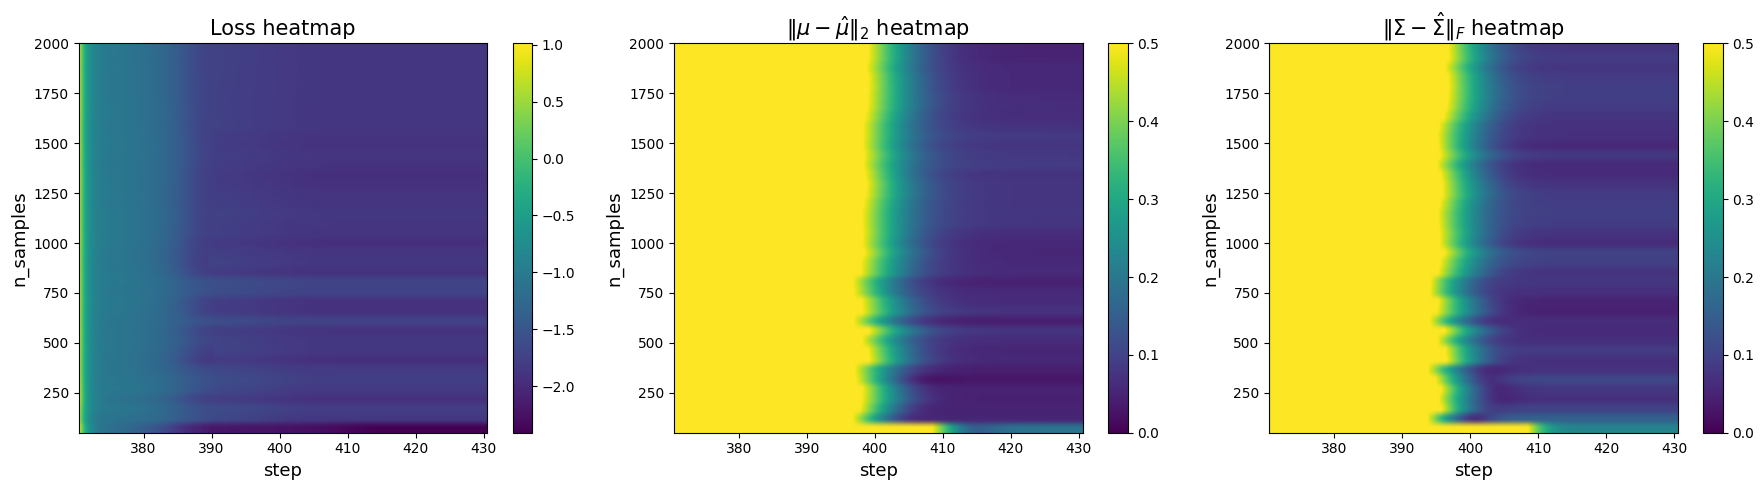

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[370], steps[430], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()